In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join('..')))

In [3]:
data = pd.read_csv("../data/toxic_comments.csv")
data.sample(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
116929,7106febb3d9c305f,"""\nAre these the mysterious """"QW Supporters""""?...",0,0,0,0,0,0
68428,b706411d1c9c23c5,"""\n\nSdedeo has it correct, O'Reilly is a care...",0,0,0,0,0,0
17496,2e37b451262ff408,Help! I'm a sockpuppet and cannot escape! Pl...,0,0,0,0,0,0
120146,828f3101b400ceca,"""\n\n False Accusation \nJust for your informa...",0,0,0,0,0,0
56904,98157ce40e534d2a,Well clearly in the coincidence page of Jerome...,0,0,0,0,0,0
26721,46d53597d9d64236,Your constant editing of other people's commen...,0,0,0,0,0,0
18760,3182ded9b63ad217,Note to admins considering unblock \n\nI'm ind...,0,0,0,0,0,0
14961,27909e0a0f8dcd2d,Instead of making the same mistake that many m...,0,0,0,0,0,0
142929,fc620ad5ef9f74eb,Thank you all so much. I am the only one addin...,0,0,0,0,0,0
59921,a069d42bfc029c4c,"If video games came out in the 60s, why is bae...",0,0,0,0,0,0


In [4]:
data.shape

(159571, 8)

In [5]:
data = data.dropna()

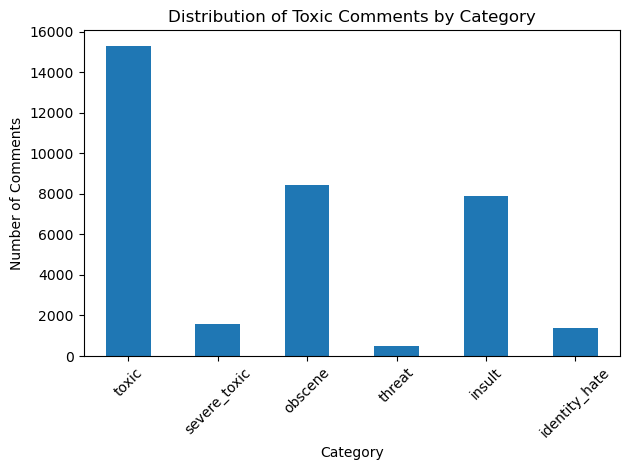

In [6]:
# Calculate the sum of each toxicity type
toxicity_counts = data.drop(["id", "comment_text"], axis=1).sum()

# Create bar plot
toxicity_counts.plot(kind='bar')
plt.title('Distribution of Toxic Comments by Category')
plt.xlabel('Category')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45)
plt.tight_layout()

<module 'matplotlib.pyplot' from '/Users/gm/ML/phishing-classifier/env/lib/python3.13/site-packages/matplotlib/pyplot.py'>

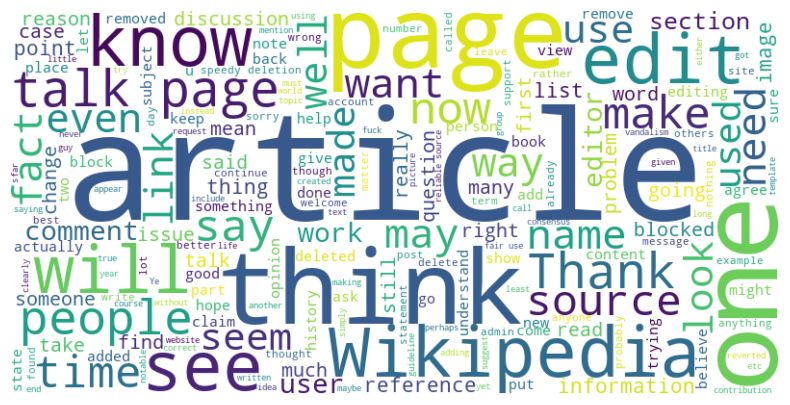

In [7]:
from wordcloud import WordCloud

# Combine all comments into a single string
text = ' '.join(data['comment_text'])

# Create and generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt

map data to labels

In [8]:
data=data.drop("id", axis=1)    
data['label'] = data.drop(['comment_text'], axis=1).max(axis=1)
data['label'] = data['label'].apply(lambda x: "toxic" if x == 1 else "safe")
data.sample(5)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label
156363,"editing Malcomx5 page, more proof of misconduct",0,0,0,0,0,0,safe
70031,WORST MOVIE EVER \n\nFROZEN SUCKS\nFROZEN SUCK...,1,0,1,0,0,0,toxic
105843,CORRECT ARTICLE ON MY USER PAGE OKAY,0,0,0,0,0,0,safe
82279,"""\n\nSpeedy deletion of Skidmore outing club\n...",0,0,0,0,0,0,safe
82213,I am concerned that Tbeatty keeps using compar...,0,0,0,0,0,0,safe


In [9]:
from modules.preprocess_text import preprocess_text

data['comment_text'] = data['comment_text'].apply(preprocess_text)
data.sample(5)

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1028)>


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label
142492,"question ira, question you. well, two actually...",1,0,1,0,1,0,toxic
72725,bignole big faggot get life stop spending day ...,1,0,0,0,0,0,toxic
143160,saw somewhere passed sgt. pepper highest selli...,0,0,0,0,0,0,safe
75019,...reliant government funding... keep question...,0,0,0,0,0,0,safe
140510,"actually, kurdish flag. would encourage write ...",0,0,0,0,0,0,safe


format for fast text

In [10]:
def format_for_fasttext(row):
    return f'__label__{row["label"]} {row["comment_text"]}'

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# Split data (70% train, 20% val, 10% test)
train, temp = train_test_split(data, test_size=0.3, random_state=42)
val, test = train_test_split(temp, test_size=0.33, random_state=42)

In [12]:
# Save train/val/test files
with open('train.txt', 'w', encoding='utf-8') as f:
    for _, row in train.iterrows():
        f.write(format_for_fasttext(row) + '\n')

with open('val.txt', 'w', encoding='utf-8') as f:
    for _, row in val.iterrows():
        f.write(format_for_fasttext(row) + '\n')

with open('test.txt', 'w', encoding='utf-8') as f:
    for _, row in test.iterrows():
        f.write(format_for_fasttext(row) + '\n')

In [1]:
import fasttext
# 4. Train fastText model
model = fasttext.train_supervised(
    input='train.txt',
    lr=0.1,         
    epoch=25,        
    wordNgrams=2,    
    dim=100,         
    loss='softmax',  
    thread=4        
)

ModuleNotFoundError: No module named 'fasttext'

In [ ]:
def evaluate_model(model, test_file):
    """Evaluate model on test set."""
    result = model.test(test_file)
    print(
        f"Precision: {result[1]:.4f}, Recall: {result[2]:.4f}, Samples: {result[0]}")

    # Detailed classification report
    test_texts = [line.strip().split(' ', 1)[1]
                  for line in open(test_file, 'r', encoding='utf-8')]
    test_labels = [line.strip().split(' ', 1)[0].replace('__label__', '')
                   for line in open(test_file, 'r', encoding='utf-8')]
    pred_labels = [model.predict(text)[0][0].replace(
        '__label__', '') for text in test_texts]
    print(classification_report(test_labels, pred_labels))


evaluate_model(model, 'test.txt')